In [1]:
# Cell 1: Data Retrieval

# We import 3 datasets:
# 1. The NQ contract data
# 2. The Nasdaq 100 instruments
# 3. The OHLCV data for the underlying asset - this will be purely for visualization

import databento as db
import os

api_key = os.environ.get('DATA_BENTO_API_KEY')
client = db.Historical(api_key)
start_time = "2024-03-18T13:44:00"
end_time = "2024-03-18T13:46:00"
dataset = 'GLBX.MDP3'
symbols = ['NQM4']
underlying_dataset = 'XNAS.ITCH'
underlying_symbols = [
    "MSFT", "AAPL", "NVDA", "AMZN", "META", "AVGO", "GOOGL", "COST", "GOOG", "TSLA",
    "AMD", "NFLX", "PEP", "ADBE", "LIN", "CSCO", "TMUS", "QCOM", "INTU", "INTC",
    "CMCSA", "AMAT", "TXN", "AMGN", "ISRG", "HON", "LRCX", "BKNG", "VRTX", "MU",
    "SBUX", "REGN", "ADP", "MDLZ", "ADI", "KLAC", "GILD", "PANW", "SNPS", "PDD",
    "CDNS", "ASML", "MELI", "CRWD", "CSX", "MAR", "ABNB", "PYPL", "ORLY", "CTAS",
    "PCAR", "MNST", "NXPI", "ROP", "WDAY", "LULU", "MRVL", "ADSK", "CEG", "CPRT",
    "DASH", "FTNT", "DXCM", "ROST", "MCHP", "ODFL", "FAST", "PAYX", "IDXX", "AEP",
    "CHTR", "KHC", "GEHC", "KDP", "MRNA", "CSGP", "AZN", "DDOG", "CTSH", "TTD",
    "EXC", "EA", "FANG", "VRSK", "CDW", "BKR", "CCEP", "ON", "BIIB", "TEAM",
    "ANSS", "ZS", "XEL", "GFS", "DLTR", "MDB", "TTWO", "WBD", "ILMN", "WBA", "SIRI"
    ]

# 'tbbo' is trades with best bid/ask
underlying_df = client.timeseries.get_range(
    dataset=underlying_dataset,
    symbols=underlying_symbols,
    schema="tbbo",
    start=start_time,
    end=end_time,
).to_df()

nq_df = client.timeseries.get_range(
    dataset=dataset,
    symbols=symbols,
    schema="tbbo",
    start=start_time,
    end=end_time,
).to_df()

nq_ohlc_df = client.timeseries.get_range(
    dataset=dataset,
    schema="ohlcv-1s",
    symbols=symbols,
    start=start_time,
    end=end_time,
).to_df()

In [68]:
# Cell 2: Trade logic
import pandas as pd
import mplfinance as mpf
from decimal import Decimal
import numpy as np

def modify_trades(df):

    previous_trade_side = None
    previous_trade_open = False
    
    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        # Check if the current row is a trade (price is not NaN)
        if pd.notna(row['price']):
            # If no trade precedes this trade, set trade_open to True
            if previous_trade_side is None:
                df.at[index, 'trade_open'] = True
            # else:
            #     df.at[index, 'trade_open'] = False

            # Previous trade_open is True and current and prev trade are either "S/S" or "B/B", remove current trade
            if previous_trade_open:
                # Cannot sell if a sell position is already open
                # If current and prev trade are both "S", remove current trade
                if row['side'] == 'S' and previous_trade_side == 'S':
                    df.loc[index, ['price', 'side', 'trade_open', 'pnl']] = np.nan
                if row['side'] == 'B' and previous_trade_side == 'B':
                    df.loc[index, ['price', 'side', 'trade_open', 'pnl']] = np.nan
                # If current and prev trade are "S/B" or "B/S", close the trade
                if row['side'] == 'S' and previous_trade_side == 'B':
                    df.at[index, 'trade_open'] = False
                    previous_trade_open = False
                    
                if row['side'] == 'B' and previous_trade_side == 'S':
                    df.at[index, 'trade_open'] = False
                    previous_trade_open = False
            else:
                # Previou trade_open is False
                df.at[index, 'trade_open'] = True
                previous_trade_side = row['side']
                previous_trade_open = df.at[index, 'trade_open']
        else:
            # If not a trade, continue without changing previous trade details
            continue


# I use float here as I don't necessarily need the precision of Decimal
fees_per_side = 1.38
nq_instrument_id = 1374

underlying_total_sells = underlying_df['side'].eq('A').sum()
underlying_total_buys = underlying_df['side'].eq('B').sum()

nq_df['nq_ask'] = nq_df['ask_px_00']
nq_df['nq_bid'] = nq_df['bid_px_00']

# Concatenate underlying_df and nq_df, then sort
nq_and_underlying_df = pd.concat([underlying_df, nq_df]).sort_index()

# Forward-fill 'nq_ask' and 'nq_bid' to ensure all rows have the most recent values
nq_and_underlying_df['nq_ask'] = nq_and_underlying_df['nq_ask'].ffill()
nq_and_underlying_df['nq_bid'] = nq_and_underlying_df['nq_bid'].ffill()

# Group by second and aggregate buy/sell counts
grouped_df = nq_and_underlying_df.groupby(nq_and_underlying_df.index.floor('S')).agg(
    underlying_total_sells=('side', lambda x: x.eq('A').sum()),
    underlying_total_buys=('side', lambda x: x.eq('B').sum()),
    nq_ask=('nq_ask', 'last'),
    nq_bid=('nq_bid', 'last')
)
# Create new dataframe to store trades
trades_df = pd.DataFrame(index=nq_ohlc_df.index, columns=['price', 'side', 'trade_open', 'trade_pnl'])

# Calculate trade conditions
buy_condition = (grouped_df['underlying_total_sells'] > grouped_df['underlying_total_buys'] * 2)
sell_condition = (grouped_df['underlying_total_buys'] > grouped_df['underlying_total_sells'] * 2)

# If the trade conditions are met, log the trade
trades_df.loc[sell_condition, 'price'] = grouped_df['nq_bid']
trades_df.loc[sell_condition, 'side'] = 'S'
trades_df.loc[buy_condition, 'price'] = grouped_df['nq_ask']
trades_df.loc[buy_condition, 'side'] = 'B'


# Modify the trade dataframe to restrict to 1 contract open at a time
modify_trades(trades_df)


# Calculate the trade's PnL
for idx, trade in trades_df.iterrows():
    if not trade['trade_open']:
        # Find the previous non-NaN price
        previous_non_nan_price = trades_df.loc[:idx, 'price'].dropna().iloc[-2]
        # Calculate trade_pnl based on the side of the trade
        if trade['side'] == 'S':
            trades_df.at[idx, 'trade_pnl'] = trade['price'] - previous_non_nan_price
        elif trade['side'] == 'B':
            trades_df.at[idx, 'trade_pnl'] = previous_non_nan_price - trade['price']
trades_df['trade_pnl'] = trades_df['trade_pnl'].fillna(0) * 20
trade_count = trades_df['price'].notna().cumsum()

# Calculate total PnL by subtracting fees for each trade
trades_df['total_pnl'] = trades_df['trade_pnl'].cumsum() - (fees_per_side * trade_count)

In [1]:
import dtale


dtale.show(trades_df)

NameError: name 'trades_df' is not defined

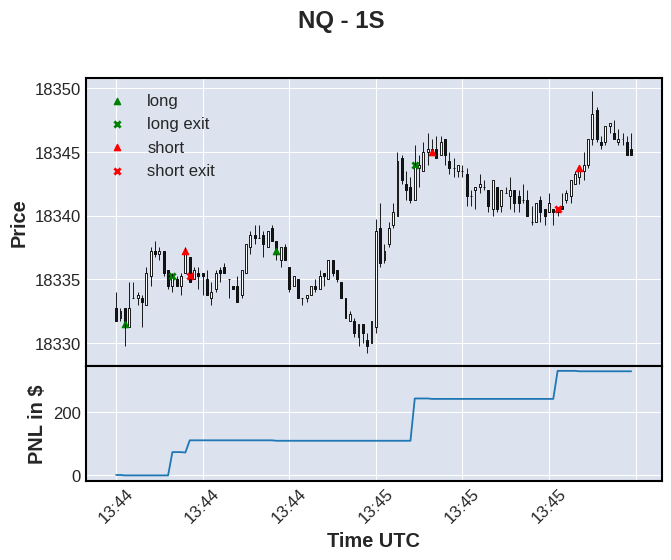

2024-05-13 20:26:49,142 - INFO     - Executing shutdown due to inactivity...
2024-05-13 20:26:49,164 - INFO     - Executing shutdown...
2024-05-13 20:26:49,166 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


In [ ]:
# Cell 4
# Splitting trades_df into two new dataframes based on the 'side' column
trades_df_buys = trades_df.copy()
# Set all rows to NaN where the 'side' is not 'B'
trades_df_buys.loc[trades_df_buys['side'] != 'B'] = np.nan
trades_df_buys_open = trades_df_buys.copy()
trades_df_buys_closed = trades_df_buys.copy()

# Set all rows to NaN where 'trade_open' is not True in trades_df_buys_open
trades_df_buys_open.loc[trades_df_buys_open['trade_open'] != True] = np.nan

# Set all rows to NaN where 'trade_open' is not False in trades_df_buys_closed
trades_df_buys_closed.loc[trades_df_buys_closed['trade_open'] != False] = np.nan

trades_df_sells = trades_df.copy()
trades_df_sells.loc[trades_df_sells['side'] != 'S'] = np.nan
trades_df_sells_open = trades_df_sells.copy()
trades_df_sells_closed = trades_df_sells.copy()

# Set all rows to NaN where 'trade_open' is not True in trades_df_buys_open
trades_df_sells_open.loc[trades_df_sells_open['trade_open'] != True] = np.nan

# Set all rows to NaN where 'trade_open' is not False in trades_df_buys_closed
trades_df_sells_closed.loc[trades_df_sells_closed['trade_open'] != False] = np.nan

buy_open_plot = mpf.make_addplot(trades_df_buys_open['price'], 
                              type='scatter', 
                              markersize=20, 
                              marker='^', 
                              color='g', 
                              label="long")
trades_df_sells_closed = mpf.make_addplot(trades_df_sells_closed['price'], 
                              type='scatter', 
                              markersize=20, 
                              marker='x', 
                              color='g', 
                              label="long exit")
buy_close_plot = mpf.make_addplot(trades_df_buys_closed['price'], 
                              type='scatter', 
                              markersize=20, 
                              marker='x', 
                              color='r', 
                              label="short exit"
                              )
trades_df_sells_open = mpf.make_addplot(trades_df_sells_open['price'], 
                              type='scatter', 
                              markersize=20, 
                              marker='^', 
                              color='r', 
                              label="short"
                              )

pnl = mpf.make_addplot(trades_df['total_pnl'],panel=1,type='line',ylabel='PNL in $')
mpf.plot(
    nq_ohlc_df,
    type="candle",
    title="NQ - 1S",
    ylabel="Price",
    xlabel="Time UTC",
    addplot=[buy_open_plot,trades_df_sells_closed, trades_df_sells_open, buy_close_plot  , pnl],
    # savefig="NQ1S-44-46",
    # warn_too_much_data=900
)



In [220]:
trades_df.to_csv('trades_df.csv', index=False)